# ============================
# Sentiment Analysis (IMDB)
# With Advanced Negation Handling & Improved Preprocessing
# ============================

In [1]:

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pickle
import warnings
warnings.filterwarnings("ignore")

# ============================
# Step 1: Load Dataset
# ============================

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

print(f"Dataset loaded successfully. Shape: {df.shape}")
print(df.head(2))

Dataset loaded successfully. Shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive


# ============================
# Step 2: Preprocessing
# ============================

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Keep negation words (don’t remove them)
negation_words = {'no', 'not', 'nor', 'neither', 'never',
                  "don't", "didn't", "doesn't", "can't", "couldn't",
                  "won't", "wouldn't", "shouldn't", "isn't", "aren't",
                  "wasn't", "weren't", "hasn't", "haven't", "hadn't"}
stop_words = stop_words.difference(negation_words)

# --- Handle common negations semantically ---
def handle_common_negations(text):
    """Convert negation phrases into semantically equivalent forms."""
    text = re.sub(r"\bnot bad\b", "good", text)
    text = re.sub(r"\bnot good\b", "bad", text)
    text = re.sub(r"\bnot great\b", "poor", text)
    text = re.sub(r"\bnot happy\b", "unhappy", text)
    text = re.sub(r"\bnot worth\b", "worthless", text)
    text = re.sub(r"\bnot interesting\b", "boring", text)
    text = re.sub(r"\bnot recommend\b", "avoid", text)
    text = re.sub(r"\bnot like\b", "dislike", text)
    return text

# --- Main preprocessing function ---
def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML
    text = re.sub(r'[^a-z\s]', '', text.lower())  # lowercase + keep alphabets
    text = handle_common_negations(text)  # fix negation meaning
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(cleaned_tokens)

print("Cleaning text data (this may take a few minutes)...")
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Text cleaning complete.")
print(df[['review', 'cleaned_review', 'sentiment']].head(2))

Cleaning text data (this may take a few minutes)...
Text cleaning complete.
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   

                                      cleaned_review sentiment  
0  one reviewer mentioned watching oz episode you...  positive  
1  wonderful little production filming technique ...  positive  


# ============================
# Step 3: TF-IDF Vectorization
# ============================

In [4]:
X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # richer vocabulary
    ngram_range=(1, 2),  # capture phrases like 'not good'
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF completed with {X_train_tfidf.shape[1]} features.")


TF-IDF completed with 10000 features.


# ============================
# Step 4: Logistic Regression Model
# ============================

In [5]:
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

model.fit(X_train_tfidf, y_train)
print("Model trained successfully.")

Model trained successfully.


# ============================
# Step 5: Evaluation
# ============================


Model Accuracy: 89.80%

Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion matrix saved as 'confusion_matrix.png'


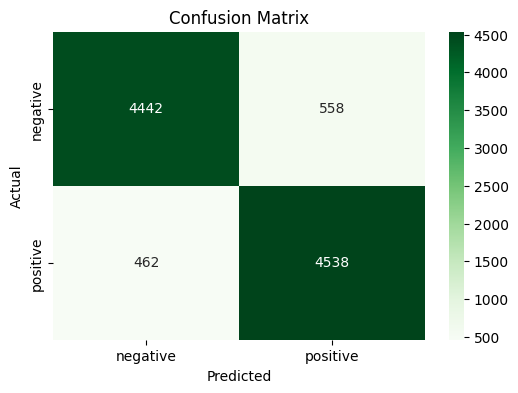

In [6]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("confusion_matrix.png")
print("Confusion matrix saved as 'confusion_matrix.png'")

# ============================
# Step 6: Save Model and Vectorizer
# ============================

In [7]:
MODEL_FILENAME = 'sentiment_model.pkl'
VECTORIZER_FILENAME = 'tfidf_vectorizer.pkl'

def save_pipeline_objects(model_obj, vectorizer_obj):
    with open(MODEL_FILENAME, 'wb') as f:
        pickle.dump(model_obj, f)
    with open(VECTORIZER_FILENAME, 'wb') as f:
        pickle.dump(vectorizer_obj, f)

save_pipeline_objects(model, tfidf_vectorizer)
print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.
